# Práctica 1: Aprendizaje automático

__Fecha de entrega: 13 de marzo de 2022__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 3 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# Apartado 1: Clustering

__Número de grupo: 5__

__Nombres de los estudiantes: Jorge Villacorta y Pablo Martinez__

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica. 

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

In [1]:
import csv
import pandas as pd
import numpy as np

prestamos = pd.read_csv('prestamos.csv')
prestamos['categoria_fico'] = 'Excelente credito'
prestamos.loc[prestamos['fico_n'] < 740, 'categoria_fico'] = 'Buen Crédito'
prestamos.loc[prestamos['fico_n'] < 680, 'categoria_fico'] = 'Credito Aceptable'
prestamos.loc[prestamos['fico_n'] < 620, 'categoria_fico'] = 'Subprime'
prestamos.loc[prestamos['fico_n'] < 550, 'categoria_fico'] = 'Pobre'

prestamos.loc[prestamos['Default'] == 1, 'Default'] = 'Default'
prestamos.loc[prestamos['Default'] == 0, 'Default'] = 'No default' 

prestamos.loc[prestamos['emp_length_n'] == 11, 'emp_length_n'] = 'Superior a 10 años'
prestamos.loc[prestamos['emp_length_n'] == 0, 'emp_length_n'] = 'No consta información'
prestamos.loc[prestamos['emp_length_n'] == 1, 'emp_length_n'] = 'Inferior a 1 año' 
prestamos.loc[prestamos['emp_length_n'] == 2, 'emp_length_n'] = 'Inferior a 2 años'   
prestamos.loc[prestamos['emp_length_n'] == 3, 'emp_length_n'] = 'Inferior a 3 años'   
prestamos.loc[prestamos['emp_length_n'] == 4, 'emp_length_n'] = 'Inferior a 4 años'   
prestamos.loc[prestamos['emp_length_n'] == 5, 'emp_length_n'] = 'Inferior a 5 años'   
prestamos.loc[prestamos['emp_length_n'] == 6, 'emp_length_n'] = 'Inferior a 6 años'   
prestamos.loc[prestamos['emp_length_n'] == 7, 'emp_length_n'] = 'Inferior a 7 años'   
prestamos.loc[prestamos['emp_length_n'] == 8, 'emp_length_n'] = 'Inferior a 8 años'   
prestamos.loc[prestamos['emp_length_n'] == 9, 'emp_length_n'] = 'Inferior a 9 años'   
prestamos.loc[prestamos['emp_length_n'] == 10, 'emp_length_n'] = 'Inferior a 10 años'   

prestamos.head()

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default,categoria_fico
0,32000,car,135000.0,18.93,687.0,MORTGAGE,Inferior a 1 año,No default,Buen Crédito
1,32000,car,90000.0,9.29,822.0,MORTGAGE,Inferior a 10 años,Default,Excelente credito
2,30000,car,95000.0,1.34,722.0,RENT,Superior a 10 años,No default,Buen Crédito
3,25750,car,230000.0,6.42,747.0,MORTGAGE,Superior a 10 años,No default,Excelente credito
4,25200,car,72000.0,30.95,692.0,OWN,Superior a 10 años,No default,Buen Crédito


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

In [2]:
prestamos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,13794.0,14507.833116,9037.938271,1000.0,7300.0,12000.000,20000.0000,40000.00
revenue,13794.0,79737.299507,56463.579892,7000.0,48000.0,68000.000,97000.0000,1650000.00
dti_n,13794.0,18.825106,9.795986,0.0,12.2,18.085,24.7575,190.87
fico_n,13794.0,699.106822,32.825754,662.0,672.0,692.000,717.0000,847.50


Medias, desviación típica, máximo, mínimo, percentiles y cantidad de las variabes numéricas vistas anteriormente.

In [3]:
prestamos.groupby('home_ownership_n')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
home_ownership_n,,,,,,,,
MORTGAGE,6850.0,90490.882996,62143.676005,12000.0,56000.0,78000.0,106000.0,1650000.0
OTHER,9.0,108333.333333,65272.505697,43000.0,63000.0,105000.0,130000.0,250000.0
OWN,1586.0,74532.390271,64981.347553,7000.0,42000.0,63000.0,90000.0,1500000.0
RENT,5349.0,67461.280596,41360.598677,8400.0,40500.0,58000.0,81250.0,600000.0


Tabla de comparación entre sueldo anual y propietario de la vivienda

In [4]:
prestamos.groupby('categoria_fico')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
categoria_fico,,,,,,,,
Buen Crédito,7423.0,81344.437411,61496.704819,7000.0,49000.00,70000.0,98650.0,1650000.0
Credito Aceptable,4740.0,74260.695662,47370.234771,8400.0,45728.05,64952.5,90000.0,840000.0
Excelente credito,1631.0,88338.965702,55324.268947,12000.0,51177.97,75000.0,107000.0,500000.0


Tabla de comparación entre sueldo anual e indicador de solvencia

In [5]:
prestamos.groupby('Default')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
Default,,,,,,,,
Default,3009.0,74832.085763,58945.883307,7000.0,45000.0,65000.0,90000.0,1650000.0
No default,10785.0,81105.847319,55677.069062,8500.0,50000.0,70000.0,99980.0,1500000.0


Tabla de comparación entre variable objetivo (incursión) y sueldo anual del solicitante del prestamo

In [6]:
prestamos.groupby('Default')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
Default,,,,,,,,
Default,3009.0,15668.212031,9045.576540,1000.0,8800.0,14000.0,21000.0,40000.0
No default,10785.0,14184.089013,9009.597893,1000.0,7000.0,12000.0,20000.0,40000.0


Tabla de comparación entre variable objetivo (incursión) y cantidad solicitada 

##### Explicación de los datos obtenidos:

Con la primera tabla podemos observar:

    Hay una diferencia notable entre el mínimo de la cantidad solicitada y el máximo, siendo la media unos 15.000 con un desviación típica de 1000. Datos que no alcanzan ninguno de los dos extremos (mínimo y máximo), por lo que tendremos gran variedad dispersa de cantidades solicitadas. Teniendo en cuenta el percentil 50, podemos suponer que nos encontraremos más valores bajos con respecto a la media, luego, serán más frecuentes cantidades de dinero bajas o en la media que más altas que esta.
    
    Notamos las mismas similitudes en la variable revenue, donde se hace más notable que la anterior la desigualdad de sueldos anuales que tenemos, desde un mínimo de 7000 hasta un máximo de 1.650.000. Ambos valores muy alejados de la media calculada de 80.000, que ni teniendo en cuenta la desviación calculada de 57.000 obenemos dichos extremos. Luego al igual que el apartado anterior, tendremos una variable muy dispersa en este rango de valores. Observando el percentil 50, al igual que en el caso anterior, observamos un mayor número de casos por debajo de la media de ingresos calculada.
    
    En el caso de la variable de endeudamiento, es más notorio el contraste del mínimo y el máximo, pero no tan relevante como las variables anteriores, pues observamos una similitud a la media calculada en el percentil 50 y 75, muy alejada del máximo calculado, por lo que suponemos que los prestamos por lo general, son aceptados dentro de unos rangos de solvencia estandares, a excepción de ciertos casos especificos.
    
    Con respecto a la variable de solvencia, y teniendo en cuenta el rango sobre el que se representa [300-850], observamos un dato claro, no se han dado prestamos a personas con una solvencia menor a 662 (crédito aceptable), pero en contraposición, es mucho más frecuente prestamos en torno a este valor o el de la media (700), que valores de solvencia más altos, por lo que deducimos que, siempre se aceptan prestamos con un mínimo razonable de garantía y es más frecuente prestamos debidos a necesidad que por cualquier otra situación, en relación al nivel de solvencia, que tendrá en cuenta las propiedades o capital de la persona que solicita el préstamo.
    
    
A continuación, valoramos las tablas de pares de variables:

    Con la tabla de comparación de propietario de la vivienda y sueldo anual, podemos ver que a mayoría de las personas que solicitan el prestamo viven de alquiler o tienen hipotecada su vivienda, habiendo mucha diferencia entre el mínimo y el máximo en ambos casos y como hemos visto antes, con mayor número de personas por debajo de la media de sueldo anual calculada. Podriamos interpretar essto como un motivo de sollicitud para la mayor parte de los casos estudiados, donde el motivo del prestamo puede ser ocasionado por el pago de las mensualidades del domicilio.
    
    En la tabla de comparación entre sueldo anual e indicador de solvencia, observamos algo esperado, y es que los prestamos menos comunes son los catalogados como excelente crédito, y la media de sueldos anuales de las personas que lo solicitan están por encima de la media general de sueldos calculada anteriormente, lo que es lógico, dado que en si mismo el indicador de solvencia tiene esto en cuenta.
    
    También podemos verificar la hipótesis que hemos realizado antes sobre el número de tipos de préstamos, dado  que vemos una gran mayoria en créditos de tipo "buen crédito", donde vemos una disparidad notoria entre el mínimo y máximo calculado y corroboramos que la mayoria de las personas solicitantes están por debajo de la media de sueldos anueales.
    En la tabla de comparación de incursión con sueldo anual, podemos ver como la mayoría de prestamos no entran en incursión (lógico, dado que si no no se concederían). Observamos disparidad de prestamos que entran en incursión observando el mínimo y el máximo, aunque fijandonos en la media y en el percentil 50, podemos suponer que los prestamos asociados a peersonas con sueldos anuales elevados son casos aislados que aumentan la media general. Fijandonos en los casos más comunes, las incursiones, en su mayoría, estan asociadas a personas que no llegan a la media de ingresos anuales ni a la media general anteriormente calculada, siendo la general más alta que la de los préstamos catalogados como default.
    
    Por último, observamos una relación de parentesco en ambos tipos de préstamos (default/no default), y es que comparten el mínimo y el máximo prestado (lo cual tambbién es lógico, puesto que se establecen unos mínimos y máximos generales y unas comisones asociadas a las diferentes cantidades). La media de la cantidad solicitada es muy parecida en ambos casos, y notamos una pequeña diferencia en relación a que la mayoría de prestamos no default están por debajo de la media solicitada, por lo que serán más comunes los prestamos de menor cantidad a la media calculada, que además, es menor que la media general calculada en la tabla general (dato que en el caso de los prestamos default no se cumple)


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

In [7]:
prestamos['categoria_fico'].value_counts()

Buen Crédito         7423
Credito Aceptable    4740
Excelente credito    1631
Name: categoria_fico, dtype: int64

<AxesSubplot:ylabel='categoria_fico'>

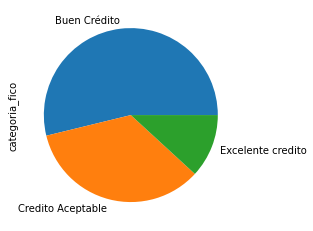

In [8]:
prestamos['categoria_fico'].value_counts().plot.pie()

Gráfico que muestra el porcentaje de categorias de prestamos concedidos

In [9]:
prestamos['home_ownership_n'].value_counts()

MORTGAGE    6850
RENT        5349
OWN         1586
OTHER          9
Name: home_ownership_n, dtype: int64

<AxesSubplot:ylabel='home_ownership_n'>

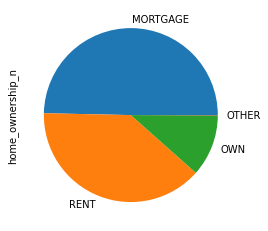

In [10]:
prestamos['home_ownership_n'].value_counts().plot.pie()

Gráfico que muestra el porcentaje de tipos de situaciones de la vivienda en la que reside el solicitante

In [11]:
prestamos['Default'].value_counts()

No default    10785
Default        3009
Name: Default, dtype: int64

<AxesSubplot:ylabel='Default'>

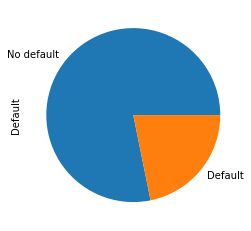

In [12]:
prestamos['Default'].value_counts().plot.pie()

Gráfico que muestra el porcentaje de solicitantes que han incumplido o no en el prestamo

In [13]:
prestamos['emp_length_n'].value_counts()

Superior a 10 años       4612
Inferior a 3 años        1232
Inferior a 1 año         1174
Inferior a 4 años        1174
Inferior a 2 años         909
No consta información     875
Inferior a 6 años         860
Inferior a 5 años         815
Inferior a 9 años         599
Inferior a 7 años         580
Inferior a 10 años        494
Inferior a 8 años         470
Name: emp_length_n, dtype: int64

<AxesSubplot:ylabel='emp_length_n'>

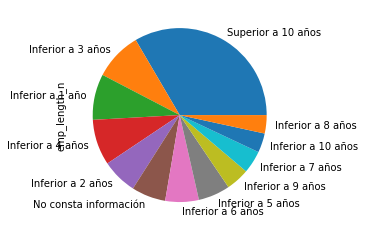

In [14]:
prestamos['emp_length_n'].value_counts().plot.pie()

Gráfico que muestra el porcentaje de permanencia de los solicitantes

<AxesSubplot:>

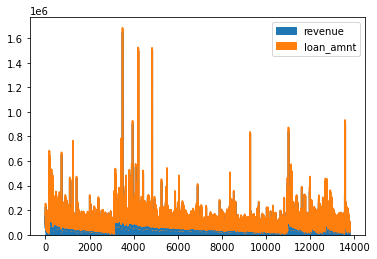

In [15]:
prestamos.loc[:,['revenue','loan_amnt']].plot.area()

Gráfico de comparación entre el sueldo anual y la cantidad solicitada

#### Explicación de los datos obtenidos

En complementación a las conclusiones del apartado anterior, y de tal manera que podamos corroborar algunas hipótesis o conclusiones hayadas, analizamos las variables categóricas. Destacamos:

    Se realizan, en mayor medida, prestamos de tipo "buen crédito" que de demas tipos.
    La mayoria de personas que solicitan el prestamo viven de alquiler o tienen su vivienda hipotecada.
    La gran mayoria de prestamos no entran en incursión.
    Predominan los prestamos aceptados a personas con una permanencia superior a 10 años, aunque hay bastante disparidad general.
    Por último, comparando los sueldos anuales con la cantidad solicitada, observamos que las cantidades más altas, no corresponden con los sueldos más altos.

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

#### Explicación

Hay que tener en cuenta que, aunque los datos son numéricos, los rangos entre ellos son muy distantes y en caso de alguno, siempre fluctua entre un rango de valores, por lo que deberemos estudiar la posibilidad de normalizar o estandarizar.

Reescalar: podría ser interesante, dado que las unidades de medida que tenemos son dolares, porcentaje y puntuacion[300-850], y tienen una escala de valores muy diferentes. Al reescalar las variables, estas toman valores entre 0 y 1.

Estandarizar: también puede ser interesante por el rango tan amplio de variables que tenemos (en los sueldos anuales por ejemplo). Al estandarizar los datos, se hace que las variables tengan media 0 y varianza 1.

In [16]:
df_scaled = prestamos.loc[:,['revenue','dti_n','fico_n']]

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
#calculamos el rango al que se va a reescalar los datos
scaler.fit(df_scaled)

scaled = scaler.transform(df_scaled) # Lo almacenamos en el dataset original

In [19]:
df_scaled = pd.DataFrame(scaled, columns = ['revenue','dti_n','fico_n'])
df_scaled.head()

,revenue,dti_n,fico_n
0,0.077906,0.099177,0.134771
1,0.050517,0.048672,0.862534
2,0.053561,0.007020,0.323450
3,0.135727,0.033635,0.458221
4,0.039562,0.162152,0.161725


In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
df_standar = prestamos.loc[:,['revenue','dti_n','fico_n']]

In [22]:
scaler = StandardScaler()

scaler.fit(df_standar)

standar = scaler.transform(df_standar) # Lo almacenamos en el dataset original

In [23]:
df_standar = pd.DataFrame(standar, columns = ['revenue','dti_n','fico_n'])
df_standar.head()

,revenue,dti_n,fico_n
0,0.978767,0.010708,-0.368834
1,0.181764,-0.973404,3.743939
2,0.270320,-1.784990,0.697440
3,2.661329,-1.266392,1.459065
4,-0.137037,1.237786,-0.216509


Utilizaremos ambas variables modificadas para ver como son afectadas por el algoritmo del siguiente apartado y así estudiar con que tipo de variables podemos encontrar el número óptimo de clusters.

## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo con la puntuación (con la función `KMeans.score()`), el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import KMeans

Vamos a estudiar el número de clusters óptimos para los datos originales, reescalados y normalizados, de esta manera veremos las diferencias en los gráficos resultantes y podremos corroborar si es necesario modificar las variables originales.

Para ello, utilizamos el algorítmo k-means que agrupa los datos en K grupos disjuntos, minimizando la suma de distancias dentro de cada cluster. Recibe como parámetro el número de clusters que debe crear.

Como tenemos 3 variables, necesitamos una proyección 3D para que se vea mejor.

In [25]:
df = prestamos.loc[:,['revenue','dti_n','fico_n']]

#### K-means con 2 clusters y los datos originales

In [26]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=2, random_state=333).fit(df)
######################################
# Agrupar los puntos en clusters
km.fit(df)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [27]:
labl = labels
xdata = df['revenue'] #ejex
ydata = df['dti_n'] #ejey
zdata = df['fico_n'] #ejez

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/2235666131.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


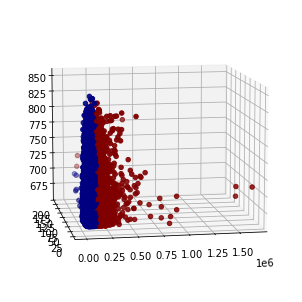

In [28]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(10, -100)
ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');

#### K-means con 3 clusters y los datos originales

In [29]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=3, random_state=333).fit(df)
######################################
# Agrupar los puntos en clusters
km.fit(df)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [30]:
labl = labels
xdata = df['revenue'] #ejex
ydata = df['dti_n'] #ejey
zdata = df['fico_n'] #ejez

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/2078660849.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


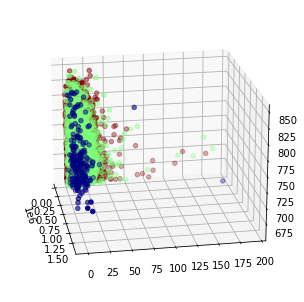

In [31]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(20, -10)
ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');

#### K-means con 2 clusters y los datos reescalados

In [32]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=2, random_state=333).fit(df_scaled)
######################################
# Agrupar los puntos en clusters
km.fit(df_scaled)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [33]:
labl = labels
xdata = df_scaled['revenue'] #ejex
ydata = df_scaled['dti_n'] #ejey
zdata = df_scaled['fico_n'] #ejez

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3899343049.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


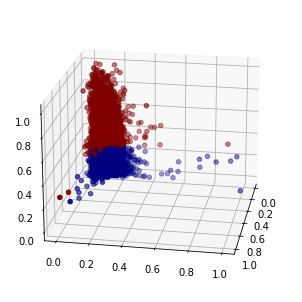

In [34]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(20, 10)
ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');

#### K-means con 3 clusters y los datos reescalados

In [35]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=3, random_state=333).fit(df_scaled)
######################################
# Agrupar los puntos en clusters
km.fit(df_scaled)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [36]:
labl = labels
xdata = df_scaled['revenue'] #ejex
ydata = df_scaled['dti_n'] #ejey
zdata = df_scaled['fico_n'] #ejez

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3058316087.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


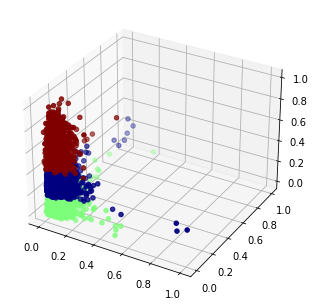

In [37]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');

#### K-means con 2 clusters y los datos normalizados

In [38]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=2, random_state=333).fit(df_standar)
######################################
# Agrupar los puntos en clusters
km.fit(df_standar)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [39]:
labl = labels
xdata = df_standar['revenue'] #ejex
ydata = df_standar['dti_n'] #ejey
zdata = df_standar['fico_n'] #ejez

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3058316087.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


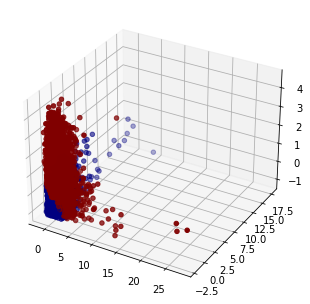

In [40]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');

#### K-means con 3 clusters y los datos normalizados

In [41]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=3, random_state=333).fit(df_standar)
######################################
# Agrupar los puntos en clusters
km.fit(df_standar)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [42]:
labl = labels
xdata = df_standar['revenue'] #ejex
ydata = df_standar['dti_n'] #ejey
zdata = df_standar['fico_n'] #ejez

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3058316087.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


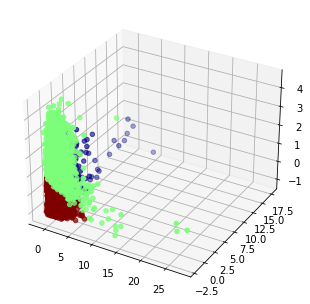

In [43]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');

#### K-means con 4 clusters y los datos normalizados

In [44]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=4, random_state=333).fit(df_standar)
######################################
# Agrupar los puntos en clusters
km.fit(df_standar)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [45]:
labl = labels
xdata = df_standar['revenue'] #ejex
ydata = df_standar['dti_n'] #ejey
zdata = df_standar['fico_n'] #ejez

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3058316087.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


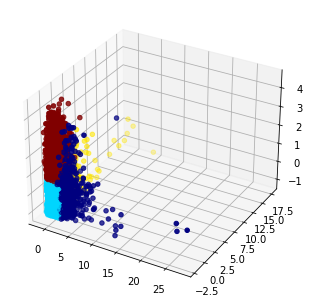

In [46]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');

### Estudiamos el número de clusters a crear mediante el índice de Davies-Bouldin

#### Para las variables escaladas:

In [47]:
from sklearn.metrics import davies_bouldin_score

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3631460335.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3631460335.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3631460335.py:13: MatplotlibDeprecationWarning: Axes3D(fig)

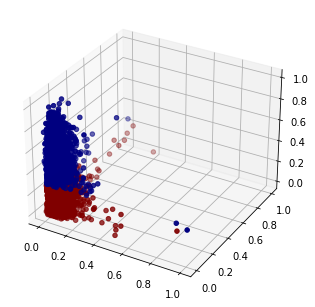

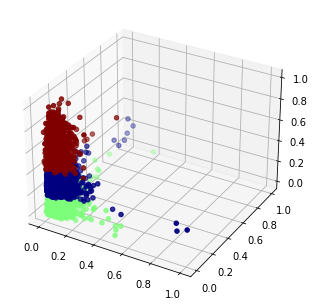

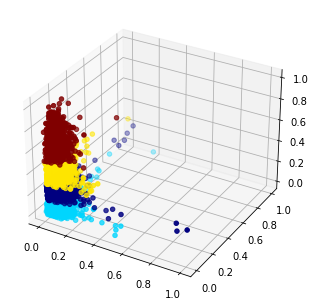

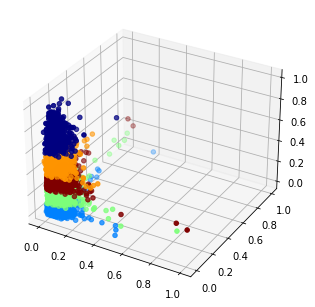

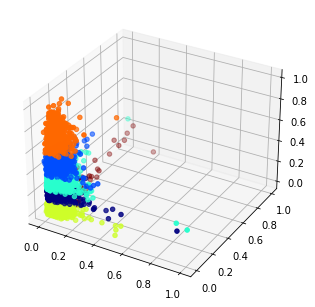

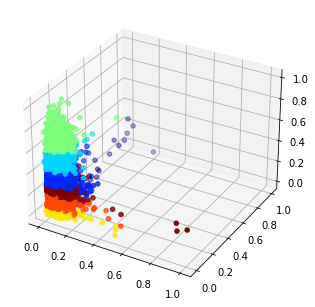

In [48]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(df_scaled)
    labels = km.labels_
    centers = km.cluster_centers_
    labl = labels
    xdata = df_scaled['revenue'] #ejex
    ydata = df_scaled['dti_n'] #ejey
    zdata = df_scaled['fico_n'] #ejez
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');
    
    davies_boulding[k-2] = davies_bouldin_score(df_scaled, km.labels_) 

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

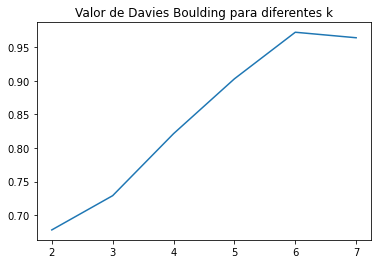

In [49]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

Vemos que la mejor agrupación es con 2 centroides para los datos escalados, obteniendo un valor de 0.65 aprox.

#### Para las variables estandarizadas:

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3326147003.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3326147003.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3326147003.py:13: MatplotlibDeprecationWarning: Axes3D(fig)

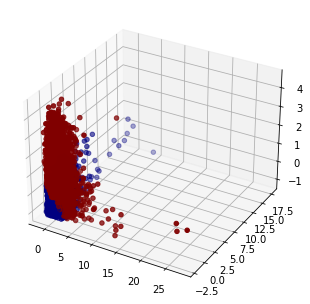

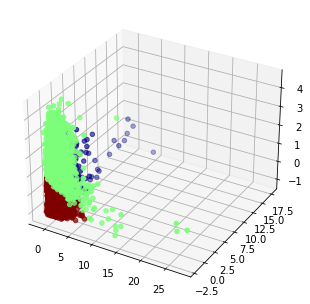

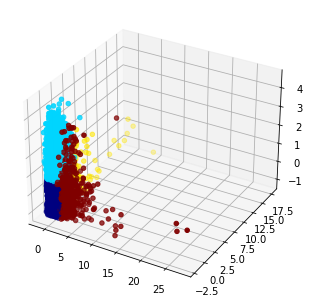

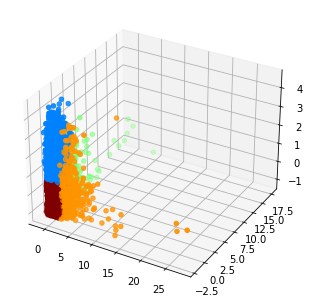

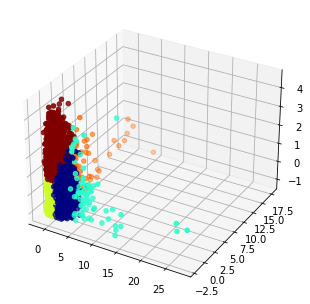

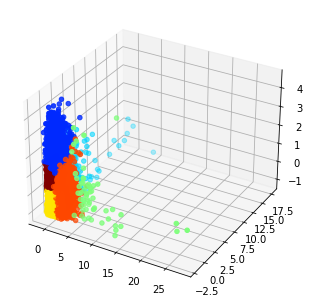

In [50]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(df_standar)
    labels = km.labels_
    centers = km.cluster_centers_
    labl = labels
    xdata = df_standar['revenue'] #ejex
    ydata = df_standar['dti_n'] #ejey
    zdata = df_standar['fico_n'] #ejez
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');
    
    davies_boulding[k-2] = davies_bouldin_score(df_standar, km.labels_) 

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

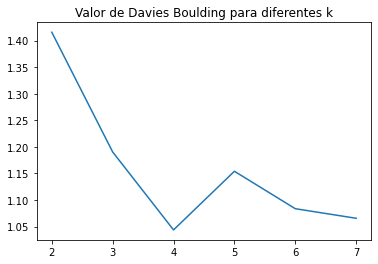

In [51]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

Vemos que la mejor agrupación es con 4 centroides para los datos estandarizados, obteniendo un valor de 1.05 aprox.

#### Para las variables originales:

C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3574564411.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3574564411.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
C:\Users\pablo\AppData\Local\Temp/ipykernel_1328/3574564411.py:13: MatplotlibDeprecationWarning: Axes3D(fig)

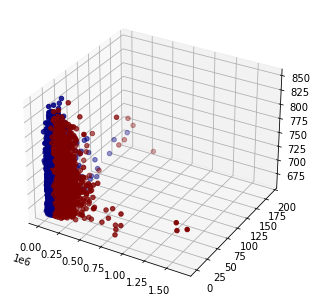

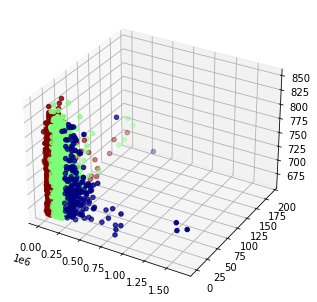

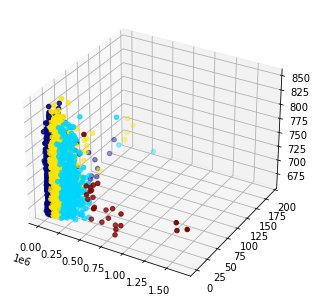

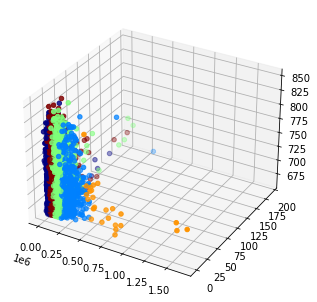

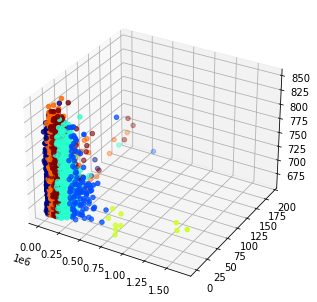

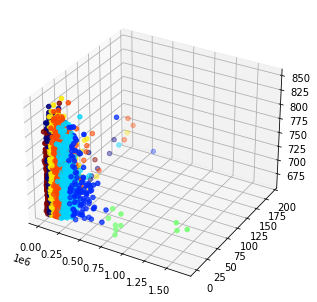

In [52]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(df)
    labels = km.labels_
    centers = km.cluster_centers_
    labl = labels
    xdata = df['revenue'] #ejex
    ydata = df['dti_n'] #ejey
    zdata = df['fico_n'] #ejez
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.scatter(xdata, ydata,zdata, c=labl, cmap='jet');
    
    davies_boulding[k-2] = davies_bouldin_score(df, km.labels_) 

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

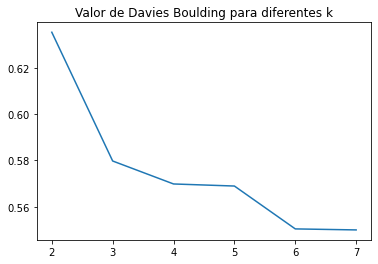

In [53]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

Vemos que la mejor agrupación es con 6,7 centroides para los datos originales, obteniendo un valor de 0.55 aprox.

#### Conclusiones Davies Boulding:

Los índices obtenidos más relevantes son:

        0.65 con 2 clusters para los datos reescalados
        
        0.55 con 6,7 clusters para los datos originales
Entre estos dos índices, dado que la diferencia entre ambos no es muy grande, es mejor optar por un numero menor de clusters, por lo que, la mejor forma de encontrar cierto patrón en las variables, según el algoritmo de kmeans, es utilizando los datos reescalados y un número de 2 clusters.

### Diagramas de codo

#### Datos originales:

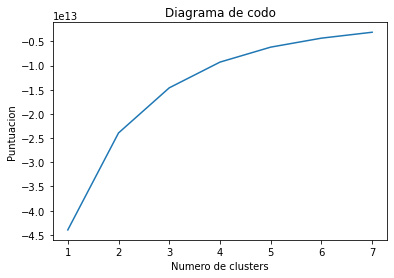

In [54]:
Nc = range(1, 8)
kmeans = [KMeans(n_clusters=i, random_state=333) for i in Nc]
kmeans
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Numero de clusters')
plt.ylabel('Puntuacion')
plt.title('Diagrama de codo')
plt.show()

#### Datos reescalados:

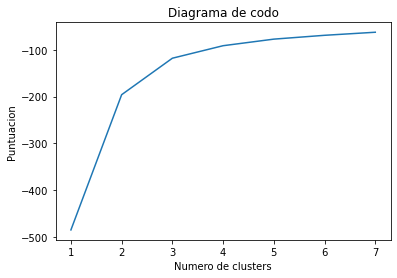

In [55]:
Nc = range(1, 8)
kmeans = [KMeans(n_clusters=i, random_state=333) for i in Nc]
kmeans
score = [kmeans[i].fit(df_scaled).score(df_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Numero de clusters')
plt.ylabel('Puntuacion')
plt.title('Diagrama de codo')
plt.show()

#### Datos estandarizados:

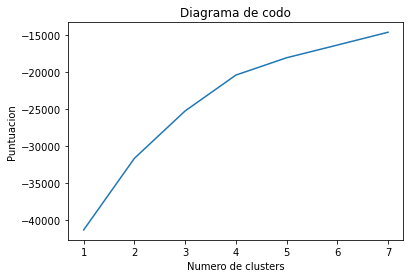

In [56]:
Nc = range(1, 8)
kmeans = [KMeans(n_clusters=i,random_state=333) for i in Nc]
kmeans
score = [kmeans[i].fit(df_standar).score(df_standar) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Numero de clusters')
plt.ylabel('Puntuacion')
plt.title('Diagrama de codo')
plt.show()

#### Conclusiones de los diagramas de codo

El único codo claro que coincide con lo previamente estudiado, es el generado por los datos reescalados, donde con 2 clusters podemos ver una posible figura de codo y coincide con el índice de Davies Boulding calculado anteriormente. 

### Coeficiente silhouette en función del número de clusters

La puntuación se define como la medida de similitud media de cada clúster con su clúster más similar, donde la similitud es la relación entre las distancias dentro del clúster y las distancias entre los clústeres. Así, los clusters más alejados y menos dispersos tendrán una mejor puntuación.

La puntuación mínima es cero, y los valores más bajos indican una mejor agrupación.

In [57]:
from sklearn.metrics import davies_bouldin_score

#### Datos originales

In [58]:
kmeans = KMeans(n_clusters=6,random_state=333).fit(df)

davies_bouldin_score(df,kmeans.labels_)

0.47557941684116284

In [59]:
kmeans = KMeans(n_clusters=7,random_state=333).fit(df)

davies_bouldin_score(df,kmeans.labels_)

0.4812031368182389

#### Datos escalados

In [60]:
kmeans = KMeans(n_clusters=2,random_state=333).fit(df_scaled)

davies_bouldin_score(df_scaled,kmeans.labels_)

0.6782751178048985

#### Datos estandarizados

In [61]:
kmeans = KMeans(n_clusters=4,random_state=333).fit(df_standar)

davies_bouldin_score(df_standar,kmeans.labels_)

1.0437166794693276

Como vimos en los apartados anteriores, obtenemos los mejores coeficientes para el número de clusters con los datos estudiados antes, y como podemos comprobar, la diferencia sigue siendo poco relevante entre la elección de 6-7 clusters para los datos originales y 2 clusters para los datos reescalados.

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3, elige 3 de ellos que sean bastante diferentes entre sí. 

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

Vamos a analizar las dos agrupaciones más prometedoras hayadas en el apartado anterior:

    2 clusters para los datos reescalados
    6 clusters para los datos originales
    
Para ello, incluimos la clase en el dataframe original para poder hacer el análisis posterior:

In [62]:
from pandas.plotting import scatter_matrix
import seaborn as sns

In [63]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=2, random_state=333).fit(df_scaled)
######################################
# Agrupar los puntos en clusters
km.fit(df_scaled)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [64]:
copydfScaled = prestamos.copy()

copydfScaled['Clusters'] = labels
copydfScaled

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default,categoria_fico,Clusters
0,32000,car,135000.0,18.93,687.0,MORTGAGE,Inferior a 1 año,No default,Buen Crédito,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,Inferior a 10 años,Default,Excelente credito,1
2,30000,car,95000.0,1.34,722.0,RENT,Superior a 10 años,No default,Buen Crédito,1
3,25750,car,230000.0,6.42,747.0,MORTGAGE,Superior a 10 años,No default,Excelente credito,1
4,25200,car,72000.0,30.95,692.0,OWN,Superior a 10 años,No default,Buen Crédito,0
...,...,...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,No consta información,No default,Excelente credito,1
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,Inferior a 8 años,No default,Excelente credito,1
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,Superior a 10 años,No default,Buen Crédito,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,No consta información,No default,Excelente credito,1


Clusters
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: revenue, dtype: object

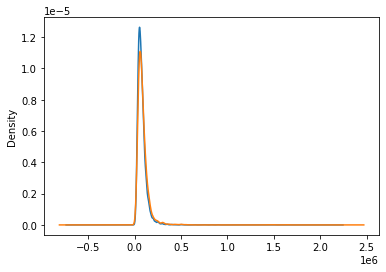

In [65]:
copydfScaled.groupby(["Clusters"])["revenue"].plot(kind="density")

Clusters
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dti_n, dtype: object

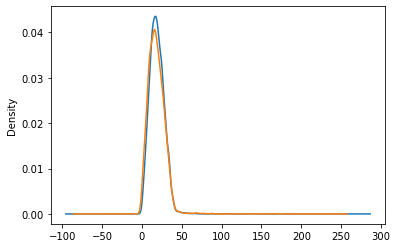

In [66]:
copydfScaled.groupby(["Clusters"])["dti_n"].plot(kind="density")

Clusters
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: fico_n, dtype: object

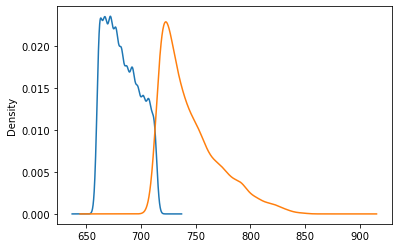

In [67]:
copydfScaled.groupby(["Clusters"])["fico_n"].plot(kind="density")

Observamos que, en base a las funciones de densidad, los clusters mantienen una distribución equitativa con respecto a las distancias entre variables para cada punto evaluado, a excepción de la variable fico, donde si observamos una difereciación que nos da a entender que el cluster 0 agrupa los prestamos de menor solvencia y el cluster 1 los que más.

In [68]:
copydfScaled.loc[copydfScaled['Clusters'] == 0, 'Clusters'] = 'Cluster 0'
copydfScaled.loc[copydfScaled['Clusters'] == 1, 'Clusters'] = 'Cluster 1' 

copydfScaledMat = copydfScaled.loc[:,['revenue','dti_n','fico_n','Clusters']]
copydfScaledMat.head()

,revenue,dti_n,fico_n,Clusters
0,135000.0,18.93,687.0,Cluster 0
1,90000.0,9.29,822.0,Cluster 1
2,95000.0,1.34,722.0,Cluster 1
3,230000.0,6.42,747.0,Cluster 1
4,72000.0,30.95,692.0,Cluster 0


A continuación, mostramos la matriz de gráficos de dispersion:

array([[<AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

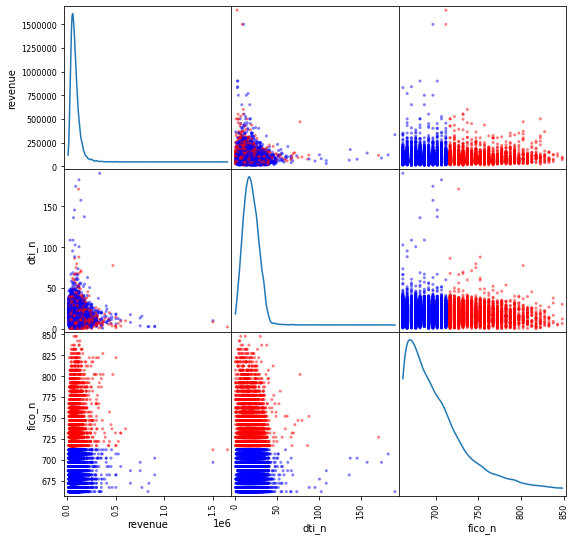

In [69]:
dic_colors = { 'Cluster 0': 'blue', 'Cluster 1': 'red'}
colors = copydfScaledMat['Clusters'].map(dic_colors)
scatter_matrix(copydfScaledMat, figsize = (9,9), diagonal = 'kde',color=colors)

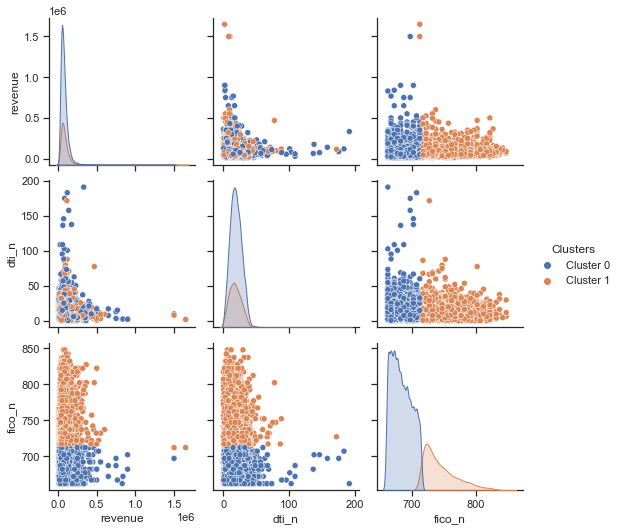

In [70]:
sns.set(style="ticks")

sns.pairplot(copydfScaledMat, hue="Clusters")

Podemos observar una gran diferenciación de los datos estudiados. El cluster 0 agrupa el conjunto de valores más bajos de las variables estudiadas, mientras que el cluster 1 agrupa los valores más grandes.
Vemos una clara diferenciazión a excepción de la compración de las variables dti y revenue, donde el diagrama muestra una gran aglomeración de los valores pertenecintes a ambos clusters.

Mostramos a continuación el número de casos que forman parte de cada cluster y la proporción de default/no default de cada uno.

<AxesSubplot:ylabel='Clusters'>

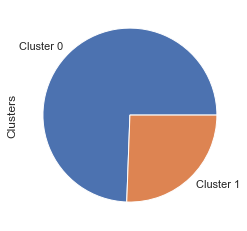

In [71]:
copydfScaled['Clusters'].value_counts().plot.pie()

array([<AxesSubplot:title={'center':'Default'}>,
       <AxesSubplot:title={'center':'No default'}>], dtype=object)

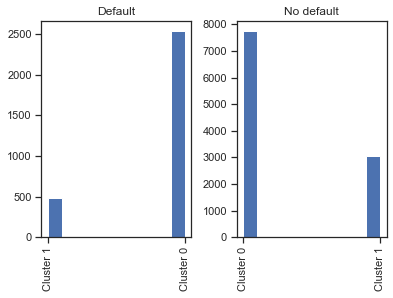

In [72]:
copydfScaled.hist('Clusters', by='Default')

Como hemos indicado anteriormente, vemos que se ha producido una diferenciación entre clusters de tal manera que en el cluster 0 predominan las personas o casos que no han incurrido en el prestamo, y en el cluster 1 obtenemos los casos contrarios.

Veamos ahora el segundo caso óptimo obtenido:

In [73]:
# Crear una instancia del agrupador k-means y agrupar los puntos en clusters
km = KMeans(init='random', n_clusters=6, random_state=333).fit(df)
######################################
# Agrupar los puntos en clusters
km.fit(df_scaled)
######################################
# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

In [74]:
copydfOriginal = prestamos.copy()

copydfOriginal['Clusters'] = labels
copydfOriginal

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default,categoria_fico,Clusters
0,32000,car,135000.0,18.93,687.0,MORTGAGE,Inferior a 1 año,No default,Buen Crédito,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,Inferior a 10 años,Default,Excelente credito,4
2,30000,car,95000.0,1.34,722.0,RENT,Superior a 10 años,No default,Buen Crédito,2
3,25750,car,230000.0,6.42,747.0,MORTGAGE,Superior a 10 años,No default,Excelente credito,1
4,25200,car,72000.0,30.95,692.0,OWN,Superior a 10 años,No default,Buen Crédito,0
...,...,...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,No consta información,No default,Excelente credito,4
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,Inferior a 8 años,No default,Excelente credito,1
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,Superior a 10 años,No default,Buen Crédito,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,No consta información,No default,Excelente credito,1


Clusters
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
Name: revenue, dtype: object

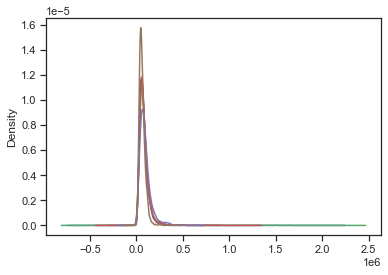

In [75]:
copydfOriginal.groupby(["Clusters"])["revenue"].plot(kind="density")

Clusters
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dti_n, dtype: object

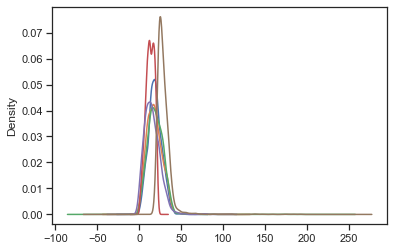

In [76]:
copydfOriginal.groupby(["Clusters"])["dti_n"].plot(kind="density")

Clusters
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
Name: fico_n, dtype: object

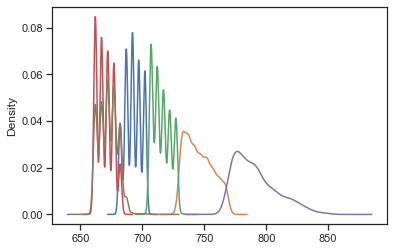

In [77]:
copydfOriginal.groupby(["Clusters"])["fico_n"].plot(kind="density")

Al igual que en el apartado anterior, bservamos que, en base a las funciones de densidad, los clusters mantienen una distribución equitativa con respecto a las distancias entre variables para cada punto evaluado, a excepción de la variable fico, donde si observamos una difereciación que nos da a entender, como en el ejemplo anterior, que se ha hecho una diferenciadción del caso con respecto a la pertenencia en cada cluster, en función de la variable fico.

In [78]:
copydfOriginal.groupby(["Clusters"]).describe().transpose()

Clusters                    0              1             2              3  \
loan_amnt count  3.600000e+03    1557.000000  2.637000e+03    3179.000000   
          mean   1.481549e+04   15396.852922  1.537016e+04   13330.402642   
          std    9.034039e+03    9703.317345  9.442838e+03    8427.713424   
          min    1.000000e+03    1000.000000  1.000000e+03    1000.000000   
          25%    8.000000e+03    7700.000000  8.000000e+03    7000.000000   
          50%    1.241250e+04   13500.000000  1.350000e+04   11200.000000   
          75%    2.000000e+04   21000.000000  2.100000e+04   18000.000000   
          max    4.000000e+04   40000.000000  4.000000e+04   40000.000000   
revenue   count  3.600000e+03    1557.000000  2.637000e+03    3179.000000   
          mean   8.026600e+04   84671.295723  8.314307e+04   82186.167905   
          std    5.810373e+04   55549.795063  6.665881e+04   55843.759018   
          min    7.000000e+03    9036.000000  1.200000e+04    8400.000000   
          25%    4.819350e+04   50000.000000  5.000000e+04   50000.000000   
          50%    6.900000e+04   72000.000000  7.000000e+04   70000.000000   
          75%    9.700000e+04  101000.000000  1.000000e+05  100000.000000   
          max    1.500000e+06  600000.000000  1.650000e+06  900000.000000   
dti_n     count  3.600000e+03    1557.000000  2.637000e+03    3179.000000   
          mean   1.866833e+01      18.140328  1.930777e+01      12.798808   
          std    7.849767e+00       9.559512  9.601411e+00       5.027920   
          min    0.000000e+00       0.000000  0.000000e+00       0.300000   
          25%    1.330000e+01      11.150000  1.273000e+01       9.170000   
          50%    1.832000e+01      17.280000  1.870000e+01      12.930000   
          75%    2.378500e+01      24.110000  2.557000e+01      16.895000   
          max    5.428000e+01      87.850000  1.713900e+02      23.000000   
fico_n    count  3.600000e+03    1557.000000  2.637000e+03    3179.000000   
          mean   6.926347e+02     745.869621  7.155248e+02     669.831079   
          std    6.507837e+00      10.984932  7.017527e+00       6.319585   
          min    6.820000e+02     732.000000  7.070000e+02     662.000000   
          25%    6.870000e+02     737.000000  7.070000e+02     662.000000   
          50%    6.920000e+02     742.000000  7.170000e+02     667.000000   
          75%    6.970000e+02     752.000000  7.220000e+02     677.000000   
          max    7.020000e+02     767.000000  7.320000e+02     682.000000   

Clusters                     4              5  
loan_amnt count     636.000000    2185.000000  
          mean    16152.319182   13561.132723  
          std     10276.687627    8203.926663  
          min      1000.000000    1000.000000  
          25%      8000.000000    7050.000000  
          50%     14137.500000   12000.000000  
          75%     24000.000000   18400.000000  
          max     40000.000000   40000.000000  
revenue   count     636.000000    2185.000000  
          mean    95576.711274   63066.635364  
          std     61742.041774   31175.127361  
          min     20000.000000    9600.000000  
          25%     55000.000000   41000.000000  
          50%     80541.500000   57000.000000  
          75%    117000.000000   78864.000000  
          max    500000.000000  332500.000000  
dti_n     count     636.000000    2185.000000  
          mean       15.144308      28.828046  
          std         9.136512      10.464375  
          min         0.000000      19.100000  
          25%         8.472500      23.960000  
          50%        14.175000      26.860000  
          75%        20.940000      31.430000  
          max        77.430000     190.870000  
fico_n    count     636.000000    2185.000000  
          mean      791.334119     672.382151  
          std        17.149585       7.331936  
          min       772.000000     662.000000  
          25%       777.000000     667.000000  
          50%     

In [79]:
copydfOriginal.loc[copydfOriginal['Clusters'] == 0, 'Clusters'] = 'Cluster 0'
copydfOriginal.loc[copydfOriginal['Clusters'] == 1, 'Clusters'] = 'Cluster 1' 
copydfOriginal.loc[copydfOriginal['Clusters'] == 2, 'Clusters'] = 'Cluster 2'
copydfOriginal.loc[copydfOriginal['Clusters'] == 3, 'Clusters'] = 'Cluster 3' 
copydfOriginal.loc[copydfOriginal['Clusters'] == 4, 'Clusters'] = 'Cluster 4'
copydfOriginal.loc[copydfOriginal['Clusters'] == 5, 'Clusters'] = 'Cluster 5' 

copydfOriginalMat = copydfOriginal.loc[:,['revenue','dti_n','fico_n','Clusters']]
copydfOriginalMat.head()

,revenue,dti_n,fico_n,Clusters
0,135000.0,18.93,687.0,Cluster 0
1,90000.0,9.29,822.0,Cluster 4
2,95000.0,1.34,722.0,Cluster 2
3,230000.0,6.42,747.0,Cluster 1
4,72000.0,30.95,692.0,Cluster 0


A continuación, mostramos la matriz de gráficos de dispersion:

array([[<AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

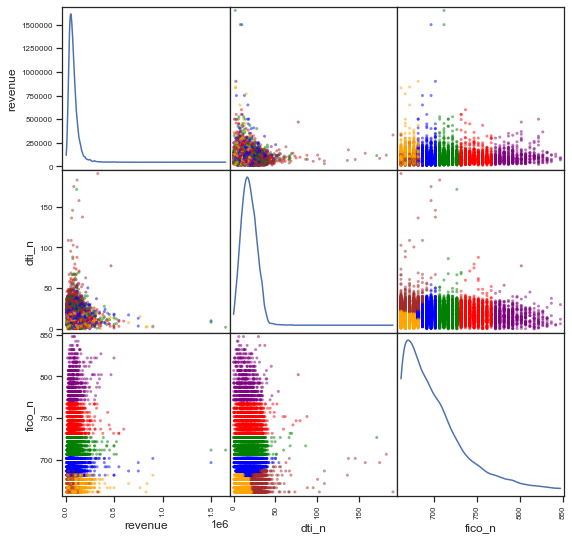

In [80]:
dic_colors = { 'Cluster 0': 'blue', 'Cluster 1': 'red', 'Cluster 2': 'green', 'Cluster 3':'orange','Cluster 4': 'purple','Cluster 5': 'brown'}
colors = copydfOriginalMat['Clusters'].map(dic_colors)
scatter_matrix(copydfOriginalMat, figsize = (9,9), diagonal = 'kde',color=colors)

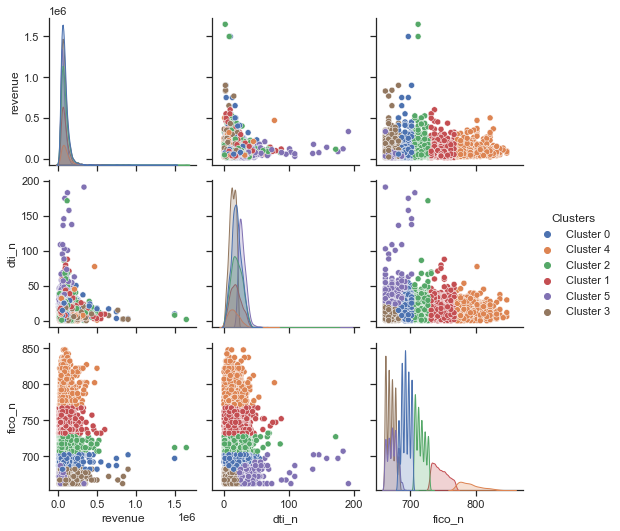

In [81]:
sns.set(style="ticks")

sns.pairplot(copydfOriginalMat, hue="Clusters")

Como indicamos en el apartado 4, donde buscabamos el óptimo de clusters, al tener demasiados clusters, vemos que no se realiza una diferenciación clara para todos, lo que puede llegar a confusión de pertenencia, sobetodo en las variables que al igual que en el apartado anterior, han sido problemáticas.

<AxesSubplot:ylabel='Clusters'>

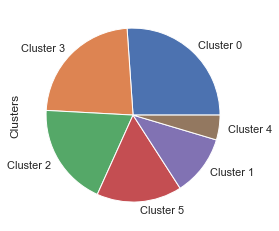

In [82]:
copydfOriginal['Clusters'].value_counts().plot.pie()

array([<AxesSubplot:title={'center':'Default'}>,
       <AxesSubplot:title={'center':'No default'}>], dtype=object)

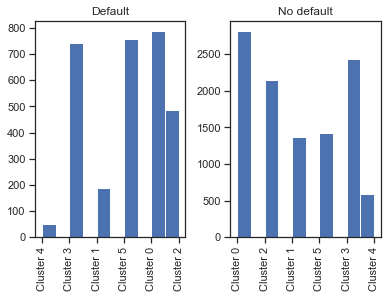

In [83]:
copydfOriginal.hist('Clusters', by='Default')

Observando estos dos gráficos, y como ya hemos explicado, es contraproducente tener demasiados clusters porque no podemos encontrar un patrón claro entre datos.